<a href="https://colab.research.google.com/github/SmithTheGreat/Romit-Ghosh-MIT-Maker-Portfolio-SRC/blob/main/Mean_Variance_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#turns current asset weights into gradient vector
def gradient(w, sigma, mu, lamb) :
  return 2*sigma@w-lamb*mu

#ensures no negative entry and sum adds up to 1
def projection_Simplified(w):
  w = np.maximum(w,0);
  return w/w.sum();

In [ ]:
def optimize(mu, sigma, lamb = 10, lr = 0.01, tolerance = 1e-6, max_times = 5000) :
  n = len(mu)
  w = np.ones(n)/n
  for i in range(max_times) :
    grade = gradient(w,sigma,mu,lamb)
    w2 = projection_Simplified(w- lr*grade)
    if np.linalg.norm(w2-w) < tolerance:
      break
    w = w2
  return w

In [ ]:
tickers = input("Enter stock tickers you wish to invest in, seperated by commas (e.g. AAPL,AMZN): ")
tickers = [t.strip().upper() for t in tickers.split(",")]
closes = yf.download(tickers, start = "2015-01-01", progress = False)["Close"]

returns = np.log(closes/closes.shift(1)).dropna()
returns.head()

Enter stock tickers you wish to invest in, seperated by commas (e.g. AAPL,AMZN): ba,infy,amzn
Enter the amount of money you would like to invest, in USD: 50


/tmp/ipython-input-84282603.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  closes = yf.download(tickers, start = "2015-01-01", progress = False)["Close"]


Ticker,AMZN,BA,INFY
Date,,,
2015-01-05,-0.020731,-0.006950,-0.012618
2015-01-06,-0.023098,-0.011848,-0.007009
2015-01-07,0.010544,0.015406,0.020880
2015-01-08,0.006813,0.017528,0.005308
2015-01-09,-0.011818,-0.001975,0.044167


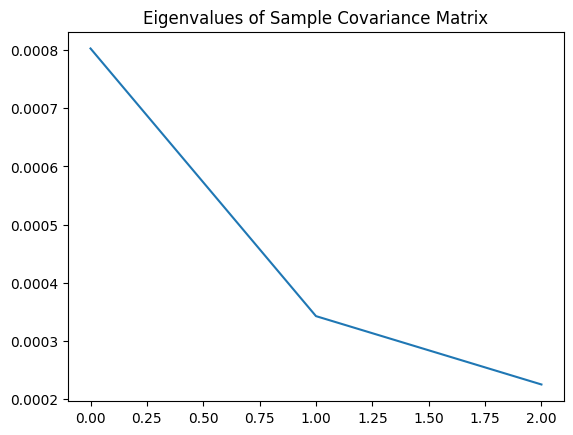

In [ ]:
mu = returns.mean().values
sample_sigma = returns.cov().values
eigenvals = np.linalg.eigvals(sample_sigma)

plt.plot(sorted(eigenvals, reverse = True))
plt.title("Eigenvalues of Sample Covariance Matrix")
plt.show()

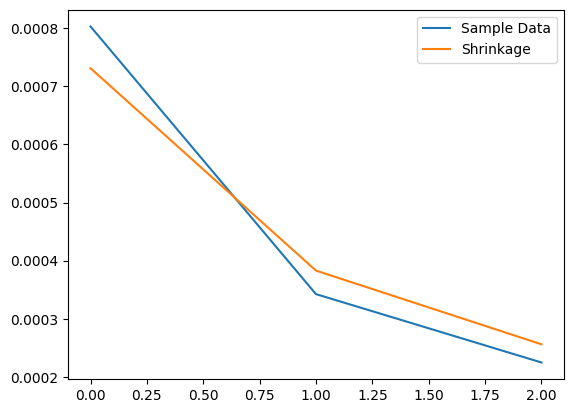

In [ ]:
shrinkage_target = np.diag(np.diag(sample_sigma))

#Can change later
alpha  = 0.3

sigma_shrinkage_covariance = alpha * shrinkage_target + (1-alpha) * sample_sigma
eigenvals_shrink = np.linalg.eigvals(sigma_shrinkage_covariance)

plt.plot(sorted(eigenvals, reverse = True), label = "Sample Data")
plt.plot(sorted(eigenvals_shrink, reverse = True), label = "Shrinkage")
plt.legend()
plt.show()


In [ ]:
weights = optimize(mu,sigma_shrinkage_covariance)
print("Sample Portfolio with lambda of 10")
pd.Series(weights,index=returns.columns, name = "Asset Weights")

Sample Portfolio with lambda of 10


,Asset Weights
Ticker,
AMZN,0.482928
BA,0.228345
INFY,0.288727


In [ ]:
portfolio_return  = mu @ weights

portfolio_variance = weights.T @ sigma_shrinkage_covariance @ weights
portfolio_volatility = np.sqrt(portfolio_variance)

print("Daily expected portfolio return: "+ str(portfolio_return))
print("Daily expected portfolio variance: "+ str(portfolio_variance))
print("Daily expected portfolio volatility: "+ str(portfolio_volatility))

Daily expected portfolio return: 0.0006429200612618071
Daily expected portfolio variance: 0.0002201212867199058
Daily expected portfolio volatility: 0.014836484985329437


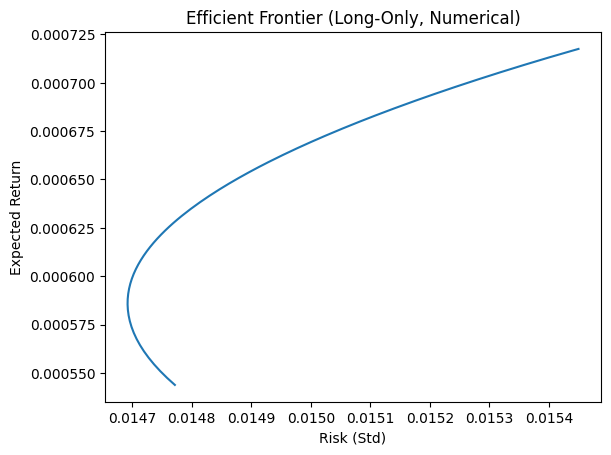

In [ ]:
lambdas = np.linspace(0, 100, 200)

frontier_risks = []
frontier_returns = []

for l in lambdas:
    w = optimize(mu, sigma_shrinkage_covariance, lamb=l)
    frontier_returns.append(mu @ w)
    frontier_risks.append(np.sqrt(w @ sigma_shrinkage_covariance @ w))

plt.plot(frontier_risks, frontier_returns)
plt.xlabel("Risk (Std)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier (Long-Only, Numerical)")
plt.show()

# **Thoughts on the effect of data frequency on estimation noise**

  I initially implemented the portfolio optimization using daily returns because it provides a large dataset to work with, which I thought would help find nuances that wouldn't be found in larger time frames. However, I noticed that the portfolios built using the daily price data was extremely susceptible to large swings in portfolio weights, with even minor changes in the data range for the price data causing these swings.

  This leads me to think that the daily price data may be causing estimation noise due to high frequency data. There is a significant amount of short term randomness in daily returns caused by investor sentiment, major company announcements(such as earnings reports), and much more. This may lead to a faulty covariance matrix, where events affecting individual stocks lead to wrongful correlation of price movements between stocks.

  To test this hypothesis, I will repeat the experiment using monthly returns, which should remove most of the noise that that came from using the daily data.

In [ ]:
#Monthly returns reduces estimation noise and better reflects realistic portfolio rebalancing timeframes
monthly_closes = closes.resample("ME").last()
monthly_returns = np.log(monthly_closes/monthly_closes.shift(1)).dropna()
monthly_returns.head()

Ticker,AMZN,BA,INFY
Date,,,
2015-02-28,0.069799,0.043170,0.074338
2015-03-31,-0.021430,-0.005117,-0.045418
2015-04-30,0.125321,-0.045949,-0.124289
2015-05-31,0.017509,-0.013481,0.028323
2015-06-30,0.011259,-0.012892,0.009291


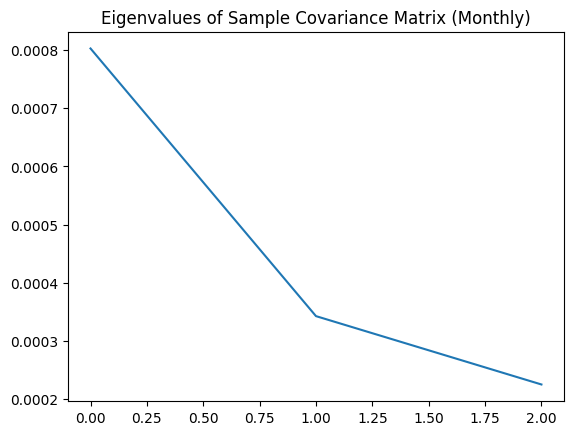

In [ ]:
monthly_mu = monthly_returns.mean().values
monthly_sample_sigma = monthly_returns.cov().values
monthly_eigenvals = np.linalg.eigvals(sample_sigma)

plt.plot(sorted(monthly_eigenvals, reverse = True))
plt.title("Eigenvalues of Sample Covariance Matrix (Monthly)")
plt.show()

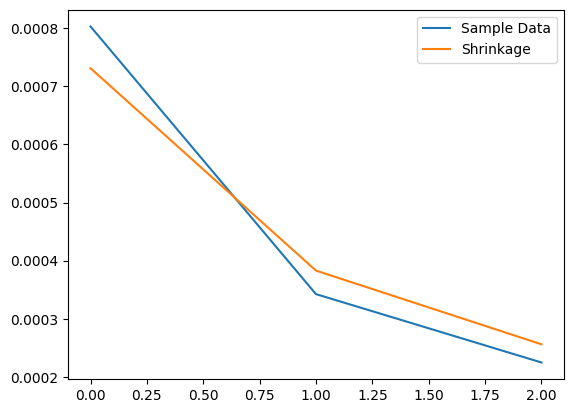

In [ ]:
monthly_shrinkage_target = np.diag(np.diag(monthly_sample_sigma))

monthly_alpha  = 0.3

monthly_sigma_shrinkage_covariance = alpha * monthly_shrinkage_target + (1-alpha) * sample_sigma
monthly_eigenvals_shrink = np.linalg.eigvals(sigma_shrinkage_covariance)

plt.plot(sorted(monthly_eigenvals, reverse = True), label = "Sample Data")
plt.plot(sorted(monthly_eigenvals_shrink, reverse = True), label = "Shrinkage")
plt.legend()
plt.show()


In [ ]:
monthly_weights = optimize(monthly_mu,monthly_sigma_shrinkage_covariance)
print("Sample Portfolio with lambda of 10")
pd.Series(monthly_weights,index=returns.columns, name = "Asset Weights")

Sample Portfolio with lambda of 10


,Asset Weights
Ticker,
AMZN,0.609986
BA,0.137733
INFY,0.252281


In [ ]:
monthly_portfolio_return  = monthly_mu @ monthly_weights

monthly_portfolio_variance = monthly_weights.T @ monthly_sigma_shrinkage_covariance @ monthly_weights
monthly_portfolio_volatility = np.sqrt(monthly_portfolio_variance)

print("Monthly expected portfolio return: "+ str(monthly_portfolio_return))
print("Monthly expected portfolio variance: "+ str(monthly_portfolio_variance))
print("Monthly expected portfolio volatility(standard deviation): "+ str(monthly_portfolio_volatility))

Monthly expected portfolio return: 0.01438727896775852
Monthly expected portfolio variance: 0.0011707824859106299
Monthly expected portfolio volatility(standard deviation): 0.03421669893357087


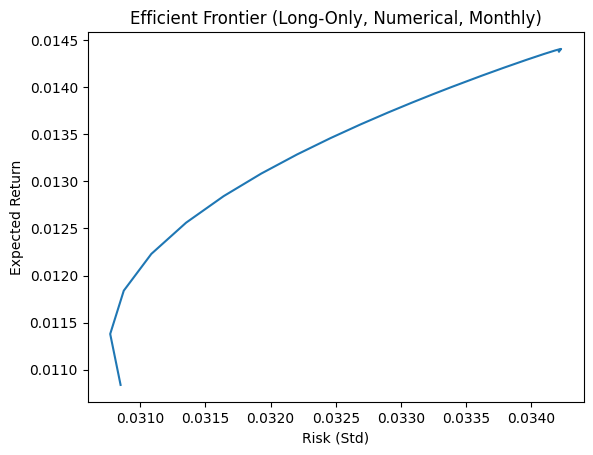

In [ ]:
monthly_lambdas = np.linspace(0, 50, 500)

monthly_frontier_risks = []
monthly_frontier_returns = []
monthly_frontier_weights = []

for l in monthly_lambdas:
    w = optimize(monthly_mu, monthly_sigma_shrinkage_covariance, lamb=l)
    monthly_frontier_returns.append(monthly_mu @ w)
    monthly_frontier_risks.append(np.sqrt(w @ monthly_sigma_shrinkage_covariance @ w))
    monthly_frontier_weights.append(w)

min_variance_idx = np.argmin(monthly_frontier_risks)
min_variance_weights = monthly_frontier_weights[min_variance_idx]
min_variance_portfolio_risk = monthly_frontier_risks[min_variance_idx]
min_variance_portfolio_return = monthly_frontier_returns[min_variance_idx]

plt.plot(monthly_frontier_risks, monthly_frontier_returns)
plt.xlabel("Risk (Std)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier (Long-Only, Numerical, Monthly)")
plt.show()

In [ ]:
print("Annualized return using daily data: " + str(((1+portfolio_return)**252)-1))
print("Annualized variance using daily data: " + str(((1+portfolio_variance)**252)-1))
print("Annualized volatility(standard deviation) using daily data: " + str(((1+portfolio_volatility)**252)-1)+"\n")

print("Annualized return using monthly data: " + str(((1+monthly_portfolio_return)**12)-1))
print("Annualized variance using monthly data: " + str(((1+monthly_portfolio_variance)**12)-1))
print("Annualized volatility(standard deviation) using monthly data: " + str(((1+monthly_portfolio_volatility)**12)-1))

Annualized return using daily data: 0.175817671398244
Annualized variance using daily data: 0.05703144953164485
Annualized volatility(standard deviation) using daily data: 39.90818833499823

Annualized return using monthly data: 0.18698582070686864
Annualized variance using monthly data: 0.014140212112553563
Annualized volatility(standard deviation) using monthly data: 0.4974024856437296


# **Reflcetion on time frame choice**
While the annualized predicted returns are nearly the same, the monthly timeframe data has a lower variance and volatility than the daily data. It makes sense why institutions rebalance their portfolio every month, aside from the fact that it means less trades to conduct, doing so also removes a lot of the estimation noise.


In [ ]:
print("Minimum Variance Portfolio:")
print(f"Expected Return: {min_variance_portfolio_return:.6f}")
print(f"Volatility: {min_variance_portfolio_risk:.6f}")
pd.Series(min_variance_weights,index=returns.columns, name = "Asset Weights")

Minimum Variance Portfolio:
Expected Return: 0.010839
Volatility: 0.030850


,Asset Weights
Ticker,
AMZN,0.343771
BA,0.286849
INFY,0.369380


In [ ]:
risk_free_rate = float(input("What's the current 1 year Treasury Yield Rate?: "))
sharpes = (np.array(monthly_frontier_returns) - ((1+risk_free_rate) ** (1/12) -1)) / np.array(monthly_frontier_risks)
idx = np.argmax(sharpes)
print("Max Sharpe Ratio: " + str(sharpes[idx]))
print("Expected Returns: " + str(monthly_frontier_returns[idx]))
print("Volatility: " + str(monthly_frontier_risks[idx]))
print("Portfolio for Max Sharpe Ratio: ")
pd.Series(monthly_frontier_weights[idx],index=returns.columns, name = "Asset Weights")

What's the current 1 year Treasury Yield Rate?: 0.0345
Max Sharpe Ratio: 0.3382110676903233
Expected Returns: 0.014402672684607098
Volatility: 0.03421578191164793
Portfolio for Max Sharpe Ratio: 


,Asset Weights
Ticker,
AMZN,0.610414
BA,0.134751
INFY,0.254836


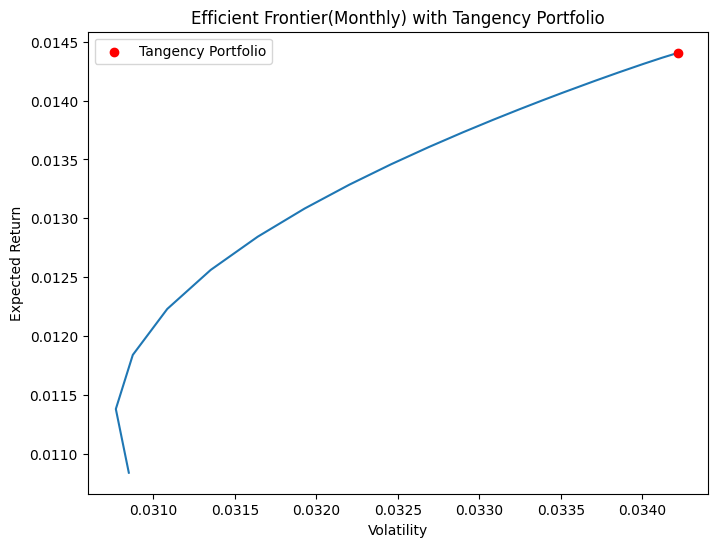

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(monthly_frontier_risks,monthly_frontier_returns)
plt.title("Efficient Frontier(Monthly) with Tangency Portfolio")
plt.scatter(monthly_frontier_risks[idx],monthly_frontier_returns[idx], color = "red",label = "Tangency Portfolio", zorder = 5)
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.legend()
plt.show()